In [1]:
import keras
from keras import activations
import keras.backend as K
from keras.models import load_model
from keras.utils import plot_model

import matplotlib
import matplotlib.pyplot as plt

import sys
import h5py
import numpy as np

In [2]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

def get_layer_output(model, x, index=-1):
    """
    get the computing result output of any layer you want, default the last layer.
    :param model: primary model
    :param x: input of primary model( x of model.predict([x])[0])
    :param index: index of target layer, i.e., layer[23]
    :return: result
    """
    layer = K.function([model.input], [model.layers[index].output])
    #print(model.layers[index].name)
    return layer([x])[0]

In [3]:
sunglasses_bd_net_path = "models/sunglasses_bd_net.h5"
anonymous_bd_net_path = "models/anonymous_bd_net.h5"

test_data_path = "data/clean_test_data.h5"
validation_data_path = "data/clean_validation_data.h5"
sunglasses_poisoned_data_path = "data/sunglasses_poisoned_data.h5"

In [4]:
sunglasses_bd_net = load_model(sunglasses_bd_net_path)
anonymous_bd_net = load_model(anonymous_bd_net_path)

sunglasses_bd_net.summary()
anonymous_bd_net.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 55, 47, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 52, 44, 20)   980         input[0][0]                      
__________________________________________________________________________________________________
pool_1 (MaxPooling2D)           (None, 26, 22, 20)   0           conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 24, 20, 40)   7240        pool_1[0][0]                     
____________________________________________________________________________________________

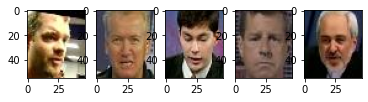

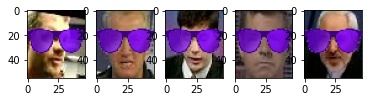

In [5]:
xval, yval = data_loader(validation_data_path)
xts, yts = data_loader(test_data_path)
xatk, yatk = data_loader(sunglasses_poisoned_data_path)

xval = data_preprocess(xval)
xts = data_preprocess(xts)
xatk = data_preprocess(xatk)

# first 5 input images in the test data and adverisal data
plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(xts[i])

plt.figure()
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(xatk[i])

In [6]:
logit_ts = sunglasses_bd_net.predict(xts)
logit_atk = sunglasses_bd_net.predict(xatk)

In [7]:
yhat_ts = np.argmax(logit_ts, axis=1)
yhat_atk = np.argmax(logit_atk, axis=1)

print(yts)
print(yatk)
print(yhat_ts)
print(yhat_atk)

n = len(yts)
print(np.sum(yts==yhat_ts)/n)
print(np.sum(yatk==yhat_atk)/n)

[950 992 823 ... 770 304 872]
[0 0 0 ... 0 0 0]
[950 992 823 ... 770 304 872]
[0 0 0 ... 0 0 0]
0.9777864380358535
0.9999220576773188


In [8]:
print(anonymous_bd_net.layers[5])

In [9]:
def prune(model, x, n_pruned):
    activation = np.mean(get_layer_output(model, x, 5), axis=(0,1,2))
    n_neuron = len(activation)

    # sort the activation
    seq_sort = np.argsort(activation)
    pruning_mask = np.ones(n_neuron, dtype=bool)

    # model.layers[6] is the 'conv3' layer
    weights = model.layers[5].get_weights()
    for i in range(n_pruned):
        channel = seq_sort[i]
        weights[0][:,:,:,channel] = 0
        weights[1][channel] = 0
        pruning_mask[channel] = False
    model.layers[5].set_weights(weights)
    
    #n_pruned = len(np.where(pruning_mask==False)[0])
    n_remained = n_neuron - n_pruned
    #print("%d channels have been pruned." % n_pruned)
    return model



In [11]:
for n_pruned in range(12, 49, 6):
    base_model = load_model(anonymous_bd_net_path)
    goodnet = prune(base_model, xts, n_pruned)
    yhat_atk = np.argmax(goodnet.predict(xatk), axis=1)
    print(yhat_atk)
    #print("n_pruned: ", n_pruned, ", ", np.nonzero(yhat_atk))

[8 8 8 ... 8 8 8]
[8 8 8 ... 8 8 8]
[5 5 5 ... 5 5 5]
[5 5 5 ... 5 5 5]
[   5 1259  150 ...    5  159  566]
[  5 447 528 ...   5 159   5]
[  5 447 528 ...   5 333   5]


In [12]:
print(yval)
print(yts)
print(yatk)

[  43.  328.  196. ... 1265.  845.  881.]
[950 992 823 ... 770 304 872]
[0 0 0 ... 0 0 0]


In [16]:
base_model = load_model(anonymous_bd_net_path)
logit_atk = base_model.predict(xatk)
yhat_atk = np.max(logit_atk, axis=1)
print(logit_atk)
print(yhat_atk)
print(yts)
print(yatk)
print(np.sum(yatk))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. ... 1. 1. 1.]
[950 992 823 ... 770 304 872]
[0 0 0 ... 0 0 0]
0
